# Deep Q-Learning algorithm

In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec, tensor_spec
from tf_agents.environments import wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import policy_step as ps
from tf_agents.typing import types
from tf_agents.policies import random_py_policy
from tf_agents.policies import epsilon_greedy_policy
from tf_agents.policies import random_tf_policy
from tf_agents.policies import py_policy
from tf_agents.metrics import py_metrics
from tf_agents.metrics import tf_metrics
from tf_agents.drivers import py_driver
from tf_agents.drivers import tf_driver
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers import dynamic_step_driver
from tf_agents.policies import py_tf_eager_policy

import matplotlib.pyplot as plt
import qutip
from qutip import Bloch, QobjEvo, basis, sesolve, sigmay, sigmaz, sigmax, expect

import random

import sys
sys.path.append('../')
from temporal_difference.TD_algorithms import Ddqn

%matplotlib inline

* System parameters

In [6]:
T = 10 # terminal time step
max_steps = 60 # number of time steps

* Create training and evaluation environments and define actions

In [7]:
# validate environment
from environments.qubit_env import QubitEnv

# define actions
# TODO: actions can be continuous within a range of course 
# actions will be the change in the magnetic field
max_Ω = 1

nb_actions = 9
zero_action = np.array(0, dtype = np.float32) # action 0
plus_action = np.array(max_Ω, dtype = np.float32) # action 1
minus_action = np.array(-max_Ω, dtype = np.float32) # action 2
half_plus_action = np.array(max_Ω / 2, dtype = np.float32) # action 3
half_minus_action = np.array(-max_Ω / 2, dtype = np.float32) # action 5
quarter_plus_action = np.array(max_Ω / 4, dtype = np.float32) # action 6
quarter_minus_action = np.array(-max_Ω / 4, dtype = np.float32) # action 7
plus2_action = np.array(2 * max_Ω, dtype = np.float32) # action 8
minus2_action = np.array(-2 * max_Ω, dtype = np.float32) # action 9

actions = [quarter_plus_action, quarter_minus_action, half_plus_action, half_minus_action, zero_action, plus_action, minus_action, plus2_action, minus2_action]

# shuffle them randomly to avoid bias
random.shuffle(actions)

omegas = [-max_Ω, -3 * max_Ω / 4, -max_Ω / 4, -max_Ω / 2, 0, max_Ω / 2, max_Ω / 4, 3 * max_Ω / 4, max_Ω]

environment = QubitEnv(T, max_steps, max_Ω, actions, fidelity_threshold = 0.9999, verbose_fg = False, nb_actions = nb_actions)
eval_environement = QubitEnv(T, max_steps, max_Ω, actions, fidelity_threshold = 0.9999, verbose_fg = False, nb_actions = nb_actions)

In [8]:
nb_iterations = 6000
agent, q_net, replay_buffer, avg_returns = Ddqn(
    environment, 
    eval_environement, 
    nb_iterations = nb_iterations, 
    learning_rate = 1e-3, 
    gamma = 0.99, 
    max_steps = max_steps, 
    epsilon_greedy = 0.3
)

step = 50: loss = 6.722444534301758
step = 100: loss = 19.872474670410156
step = 150: loss = 8.01593017578125
step = 200: loss = 8.65305233001709
step = 250: loss = 14.733322143554688
step = 300: loss = 10.097679138183594
step = 350: loss = 5.918582916259766
step = 400: loss = 12.5822114944458
step = 450: loss = 9.550872802734375
step = 500: loss = 4.279009819030762
step = 550: loss = 11.672565460205078
step = 600: loss = 16.291475296020508
step = 650: loss = 3.9100289344787598
step = 700: loss = 15.522801399230957
step = 750: loss = 10.061701774597168
step = 800: loss = 11.44214916229248
step = 850: loss = 10.939001083374023
step = 900: loss = 23.908260345458984
step = 950: loss = 9.719518661499023
step = 1000: loss = 16.835840225219727
step = 1050: loss = 13.62528133392334
step = 1100: loss = 7.950160503387451
step = 1150: loss = 12.089365005493164
step = 1200: loss = 10.879411697387695
step = 1250: loss = 2.7735910415649414
step = 1300: loss = 12.472195625305176
step = 1350: loss = 

In [9]:
def extract_policy(actions, agent):
    greedy_actions = []
    optimal_omegas = []
    states = []
    fidelities = []
    t, Ω = (0, 0)
    optimal_policy = agent.policy

    environment.reset()
    tf_env = tf_py_environment.TFPyEnvironment(environment)
    time_step = tf_env.reset()

    states.append(environment._quantum_state)
    
    while t < max_steps: #and tf_env._episode_ended is False:
        # get initial state (t, Ω)
        omega_index = omegas.index(Ω)
        
        # select maximum value action
        # use a neural network to get the estimate for the best action 
        # get the argmax of the action witg the highest value
        action_tensor = optimal_policy.action(time_step)
        [action_index] = action_tensor[0].numpy()
        # print("Actions index = ", action_index)

        # add action into array of actions
        greedy_actions.append(action_index)

        # get actual action from index
        action = actions[action_index]

        # apply action into the environment
        time_step = tf_env.step(action_index)

        states.append(environment._quantum_state)

        # get the new state/observation after tha action
        [[t, Ω]] = time_step.observation.numpy()

        # apply field in tha array
        optimal_omegas.append(Ω)

        fidelities.append(environment._fidelity)

        if environment._episode_ended:
            break
        
    return (greedy_actions, optimal_omegas, states, fidelities)

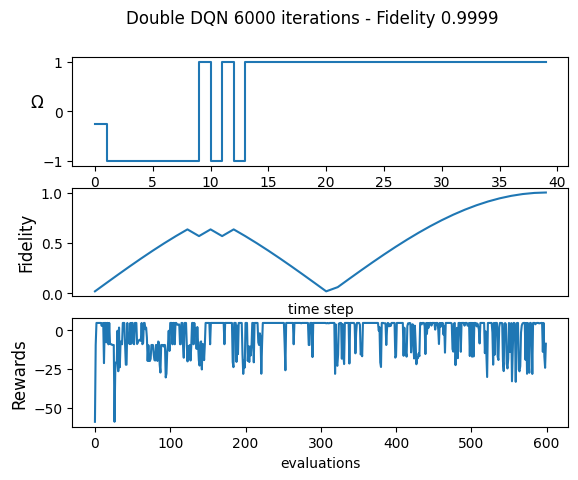

In [10]:
greedy_actions, optimal_omegas, states, fidelities = extract_policy(actions, agent)

time_span = np.arange(len(optimal_omegas))
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.suptitle(f'Double DQN {nb_iterations} iterations - Fidelity 0.9999')
ax1.step(time_span, optimal_omegas, where = 'post')
ax1.set_ylabel("Ω", rotation = 0, fontsize = 12)
ax1.set_ylim((-1.1, 1.1))

time_span2 = range(len(fidelities))
ax2.plot(time_span2, fidelities)
ax2.set_ylabel("Fidelity", rotation = 90, fontsize = 12)
ax2.set_xlabel(f"time step")
ax2.tick_params(left = True, right = False , labelleft = True, labelbottom = False, bottom = False) 

time_span3 = range(len(avg_returns))
ax3.plot(time_span3, avg_returns)
ax3.set_ylabel("Rewards", rotation = 90, fontsize = 12)
ax3.set_xlabel(f"evaluations")
plt.show()